In [12]:
import os 
import numpy as np
import healpy as hp
import costi
import matplotlib.pyplot as plt
from costi import (
    Configs,
    get_params,
    component_separation,_get_data_simulations_, _get_noise_simulation, _get_cmb_simulation, _get_data_foregrounds_)
from costi.routines import _EB_to_QU, _get_needlet_windows_, _slice_data
from costi._seds import _get_CMB_SED
from costi._compsep import estimate_residuals

%matplotlib inline

In [2]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [8]:
config_path = os.getcwd() + "/configs/config_sosats.yaml"

config: Configs = get_params(config_path=config_path)
print("Loaded configuration from\n", config_path)

Loaded configuration from
 /home/alecarones/Post-Doc/develop_code_nilcs/configs/config_sosats.yaml


In [6]:
config

Configs(config_path='/home/alecarones/Post-Doc/develop_code_nilcs/configs/config_sosats.yaml', config={'lmin': 32, 'nside': 64, 'lmax': 128, 'data_type': 'maps', 'fwhm_out': 30.0, 'nsim_start': 0, 'nsims': 1, 'parallelize': False, 'verbose': False, 'foreground_models': ['d1', 's1'], 'experiment': 'SO_SAT', 'bring_to_common_resolution': True, 'input_beams': 'gaussian', 'beams_path': '', 'field_in': 'QU', 'field_out': 'B', 'units': 'uK_CMB', 'coordinates': 'G', 'generate_input_simulations': True, 'return_fgd_components': False, 'bandpass_integrate': False, 'seed_noise': None, 'seed_cmb': None, 'cls_cmb_path': '/home/alecarones/Post-Doc/develop_code_nilcs/data/Cls_Planck2018_for_PTEP_2020_r0.fits', 'save_input_simulations': True, 'load_input_simulations': False, 'pixel_window_in': False, 'data_path': '/home/alecarones/Post-Doc/develop_code_nilcs/inputs/SO_SAT/total/total_maps_ns64_lmin32', 'fgds_path': '/home/alecarones/Post-Doc/develop_code_nilcs/inputs/SO_SAT/foregrounds/d1s1/foreground

In [4]:
# foregrounds is a SimpleNamespace with attribute 'total'. Independent components are stored in corresponding attributes.
foregrounds = _get_data_foregrounds_(config)
print(foregrounds.total.shape)

(6, 3, 49152)


In [5]:
# data will have different attributes: 'total', 'fgds', 'noise', 'cmb, all with shape (N_freq,N_fields,N_pix)
# The only required attribute for running compsep is that data has 'total' attribute

data = _get_data_simulations_(config, foregrounds, nsim=0)
print(data.fgds.shape,data.noise.shape,data.cmb.shape)

(6, 3, 49152) (6, 3, 49152) (6, 3, 49152)


In [13]:
# Compsep runs to be run

config.compsep_runs

[{'method': 'ilc',
  'domain': 'needlet',
  'needlet_config': [{'needlet_windows': 'cosine'},
   {'ell_peaks': [0, 100, 150]}],
  'ilc_bias': 0.0,
  'reduce_bias': False,
  'save_needlets': True,
  'save_weights': True},
 {'method': 'gilc',
  'domain': 'needlet',
  'needlet_config': [{'needlet_windows': 'cosine'},
   {'ell_peaks': [0, 50, 100]}],
  'ilc_bias': 0.0,
  'adapt_nside': False}]

## Importing the SO hits map and creating SO patch

0.3586832682291667


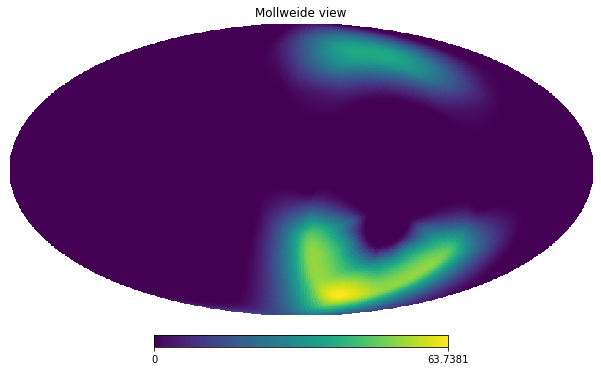

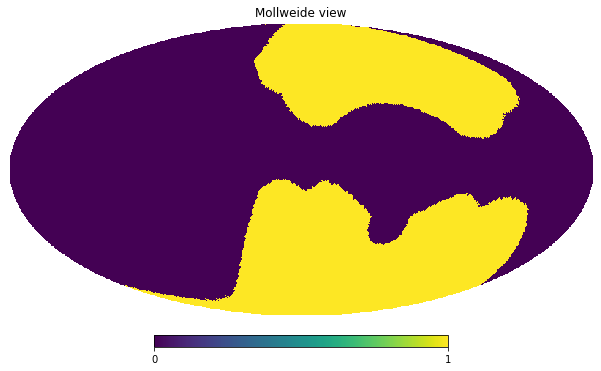

In [6]:
hits_SO = hp.read_map(os.getcwd() + '/data/norm_nHits_SA_35FOV_ns512.fits')
hits_SO = change_coord(hits_SO, ['C','G'])
hits_SO_nside = hp.ud_grade(hits_SO,nside_out=config.nside,power=-2)
hp.mollview(hits_SO_nside)
# hp.get_nside(hits_SO_nside)
mask_SO = np.zeros(12 * config.nside**2)
mask_SO[hits_SO_nside > 0.] = 1.
hp.mollview(mask_SO)
print(mask_SO.mean())

## Run with input B-mode maps reconstructed over the full sky

In [9]:
config.field_in = "QU"
config.field_out = "B"
config.mask_type = "mask_for_compsep" #"observed_patch" #
print(config.leakage_correction)

#extracting fields you need for compsep as specified in config.field_in
combined_data = _slice_data(data, "TQU", config.field_in)
print(combined_data.total.shape)
#running component separation
component_separation(config, combined_data, nsim=0, mask=mask_SO)


None
(6, 2, 49152)


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to

## Get estimate of foreground residuals from GNILC

In [13]:
# It reads the needed paths (gnilc_path and compsep_path) from config file

config.field_in = "B" # Field of GNILC run to read
config.field_out = "B"
config.mask_type = "mask_for_compsep" #"observed_patch" #

estimate_residuals(config, nsim=0, mask=mask_SO)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


## Realistic run where B-mode input maps are obtained from masked QU maps

In [10]:
config.field_in = "QU"
config.field_out = "B"
config.mask_type = "observed_patch" #
config.leakage_correction = "B_recycling" #None # "B_recycling_iterations3"

#extracting fields you need for compsep as specified in config.field_in
combined_data = _slice_data(data, "TQU", config.field_in)
print(combined_data.total.shape)
#running component separation
component_separation(config, combined_data, nsim=0, mask=mask_SO)


(6, 2, 49152)
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.
Performing recycling purification.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to